In [1]:
import os
import numpy as np
import pandas as pd
import sys

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, DMatrix
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report


LOAD DATA

In [2]:
#train = pd.read_csv('train_i_EXPERIMENTS.csv')   -----> PREVIOUS SET

train = pd.read_csv('train_VOXELEXP.csv')
val = pd.read_csv('val_VOXELEXP.csv')
data = pd.concat([train, val], ignore_index=True)

In [3]:
## GPT snippet

# Step 1: Load the data
train = pd.read_csv('train_BINEXP.csv')
val = pd.read_csv('val_BINEXP.csv')
data = pd.concat([train, val], ignore_index=True)

train_vox = pd.read_csv('train_VOXELEXP.csv')
val_vox = pd.read_csv('val_VOXELEXP.csv')
data_vox = pd.concat([train_vox, val_vox], ignore_index=True)

# Step 2: Remove all columns starting with "V" except "V_points"
columns_to_keep = [col for col in data.columns if not (col.startswith('V') and col != 'V_points')]
data = data[columns_to_keep]

# Step 3: Select columns from data_vox that start with "0", "1", "2", and "3"
vox_columns_to_add = [col for col in data_vox.columns if col[0] in '0123']

# Step 4: Rename these selected columns by moving the leading number to the end
new_vox_columns = {col: col[1:] + col[0] for col in vox_columns_to_add}

# Step 5: Rename the columns in data_vox
data_vox_renamed = data_vox.rename(columns=new_vox_columns)

# Step 6: Add these renamed columns to data
data = pd.concat([data, data_vox_renamed[list(new_vox_columns.values())]], axis=1)

# Display the modified data
data.head()

,area_code,label,hrange,hmax,imax_0,imin_0,imean_0,isk_0,ikut_0,istd_0,...,V_kut2,V_p902,V_min3,V_mean3,V_max3,V_median3,V_std3,V_sk3,V_kut3,V_p903
0,B,1646,7.55,11.54,39.0,0.0,18.477876,0.005776,-1.174685,9.734618,...,1.008523,13.3,1,17.380952,61,15.0,17.183814,1.075210,0.182321,47.0
1,A,26433,4.67,14.86,35.0,2.0,20.257862,-0.445790,-0.711099,8.303378,...,-0.409087,20.2,3,26.650000,76,21.0,22.530590,0.871992,-0.398032,61.2
2,A,5124,8.64,10.66,41.0,2.0,19.764151,-0.016397,-0.409098,8.859013,...,0.418697,20.7,1,26.111111,106,16.0,27.298532,1.341273,0.938653,69.4
3,B,11234,14.92,19.80,788.0,0.0,15.810559,17.129111,299.728069,43.701608,...,0.527166,19.0,1,24.581395,110,20.0,22.690263,1.681474,3.184317,52.2
4,B,11496,13.15,17.96,51.0,0.0,17.087574,0.065006,-0.792949,8.887430,...,0.870770,24.0,1,31.736264,142,18.0,31.516204,1.212086,0.872523,77.0


SELECT SPECIES

In [30]:
data = data[data['species'].isin([1,2,3,4,5])]

GROUP SPECIES

In [4]:
data['species'] = data['species'].apply(lambda x: x if x in [1,2] else 3)

CREATE X and Y

In [5]:
# remove area codes and labels from data
data = data.drop(['area_code', 'label'], axis=1)

X = data.drop('species', axis=1)
y = data['species']

y = y-1

HELPER FUNCTION FOR FEATURE SELECTION

In [6]:
def get_used_feats_names(feats_frame_columns, features_list):
    """
    not all features saved in the features.csv will be used.
    so we need to select which features are used.
    :param feats_frame_columns: all feaetures' names
                example [hrange, hmax, imax_0, imin_0, ..., imax_1,..., isk_2, ikut_2, ip90_2]
                "h" or "i": feature's name.
                    h: height, i:intensity
    :param features_list: the features' list which will be considered.
                example [h, i_max_min_sk]
                the format of "i_max_min_sk" means that only max, min, sk subfeatures for intensity will be used.
    :return:
    """
    feats_names = feats_frame_columns  # np.arr, dtype=object
    used_feats_bool = []

    for f_considered in features_list:
        if "_" in f_considered:
            f_i_subattrs = np.zeros(shape=len(feats_names)).astype("bool")
            f_name = f_considered.split("_")[0]   # feature type info. e.g. "h"(height), "i"(intensity)
            f_i_sub = f_considered.split("_")[1:] # feature sub info. e.g. "max", "min"
            f_i_sub_channels = list(filter(lambda _:_ in ["ch0", "ch1", "ch2", "ch3"], f_i_sub)) # channel info: e.g.: "ch1"
            for fi, fn in enumerate(feats_names): # fn e.g.: "imax_1", "imin_1"
                if fn[0]==f_name: # judge h or i
                    for s in f_i_sub: # s e.g. "max", "min", "ch1"
                        if str(s) in fn or s.replace("ch", "")==fn.split("_")[-1]: # e.g.: "max" in "imax_1" and ch"1"==imax_"1"
                            if len(f_i_sub_channels)==0: # no channel info. so this feature will be considered without the channel filter
                                f_i_subattrs[fi] = True
                            elif "ch"+str(fn)[-1] in f_i_sub_channels: # filter the feature info by channel.
                                f_i_subattrs[fi] = True
            used_feats_bool.append(f_i_subattrs)
        else:
            used_feats_bool.append([_[0] == f_considered for _ in feats_names])

    used_feats_bool = np.sum(used_feats_bool, axis=0, dtype=bool)  # 1-d list, all columns name which will be considered
    used_feats_names= feats_names[used_feats_bool]

    if 'D_1' in features_list and 'D_10' not in features_list:
        used_feats_names = used_feats_names[used_feats_names != 'D10']


    return used_feats_names

feats_cols = np.array(['hrange', 'hmax', 'hstd', 'hmean' ,'imax_0', 'imin_0', 'imean_0', 'isk_0', 'ikut_0', 'ip90_0',
 'imax_1', 'imin_1', 'imean_1', 'isk_1', 'ikut_1', 'ip90_1', 'imax_2', 'imin_2',
 'imean_2', 'isk_2', 'ikut_2', 'ip90_2','Rmin_0', 'Rmin_1', 'Rmin_2','Rp90_0', 'Rp90_1', 'Rp90_2', 'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10', 'penetration',
 'Rmean_0', 'Rmean_1', 'Rmean_2', 'Rmax_0', 'Rmax_1', 'Rmax_2', 'Rkut_0', 'Rkut_1', 'Rkut_2', 'Rsk_0', 'Rsk_1', 'Rsk_2', 
 'V_min1', 'V_mean1', 'V_max1', 'V_median1', 'V_std1', 'V_sk1', 'V_kut1', 'V_p901', 'V_points',
 'V_min2', 'V_mean2', 'V_max2', 'V_median2', 'V_std2', 'V_sk2', 'V_kut2', 'V_p902',
 'V_min3', 'V_mean3', 'V_max3', 'V_median3', 'V_std3', 'V_sk3', 'V_kut3', 'V_p903',
 'V_min0', 'V_mean0', 'V_max0', 'V_median0', 'V_std0', 'V_sk0', 'V_kut0', 'V_p900',

'2binm1_0', '2binx1_0','2binm2_0','2binx2_0',
'2binm1_1', '2binx1_1','2binm2_1','2binx2_1',
'2binm1_2', '2binx1_2','2binm2_2','2binx2_2',

'3binm1_0','3binx1_0', '3binm2_0','3binx2_0', '3binm3_0','3binx3_0',
'3binm1_1','3binx1_1', '3binm2_1','3binx2_1', '3binm3_1','3binx3_1',
'3binm1_2','3binx1_2', '3binm2_2','3binx2_2', '3binm3_2','3binx3_2',

'4binm1_0','4binx1_0', '4binm2_0','4binx2_0', '4binm3_0','4binx3_0', '4binm4_0','4binx4_0',
'4binm1_1','4binx1_1', '4binm2_1','4binx2_1', '4binm3_1','4binx3_1', '4binm4_1','4binx4_1',
'4binm1_2','4binx1_2', '4binm2_2','4binx2_2', '4binm3_2','4binx3_2', '4binm4_2','4binx4_2',

'5binm1_0','5binx1_0', '5binm2_0','5binx2_0', '5binm3_0','5binx3_0', '5binm4_0','5binx4_0', '5binm5_0','5binx5_0',
'5binm1_1','5binx1_1', '5binm2_1','5binx2_1', '5binm3_1','5binx3_1', '5binm4_1','5binx4_1', '5binm5_1','5binx5_1',
'5binm1_2','5binx1_2', '5binm2_2','5binx2_2', '5binm3_2','5binx3_2', '5binm4_2','5binx4_2', '5binm5_2','5binx5_2',

'10binm1_0','10binx1_0', '10binm2_0','10binx2_0', '10binm3_0','10binx3_0', '10binm4_0','10binx4_0', '10binm5_0','10binx5_0',
'10binm6_0','10binx6_0', '10binm7_0','10binx7_0', '10binm8_0','10binx8_0', '10binm9_0','10binx9_0', '10binm10_0','10binx10_0',

'10binm1_1','10binx1_1', '10binm2_1','10binx2_1', '10binm3_1','10binx3_1', '10binm4_1','10binx4_1', '10binm5_1','10binx5_1',
'10binm6_1','10binx6_1', '10binm7_1','10binx7_1', '10binm8_1','10binx8_1', '10binm9_1','10binx9_1', '10binm10_1','10binx10_1',

'10binm1_2','10binx1_2', '10binm2_2','10binx2_2', '10binm3_2','10binx3_2', '10binm4_2','10binx4_2', '10binm5_2','10binx5_2',
'10binm6_2','10binx6_2', '10binm7_2','10binx7_2', '10binm8_2','10binx8_2', '10binm9_2','10binx9_2', '10binm10_2','10binx10_2',
 

 'istd_0', 'irange_0', 'ip5_0', 'ip10_0', 'ip20_0', 'ip30_0', 'ip40_0', 'ipmedian_0', 'ip60_0', 'ip70_0', 'ip80_0',
 'istd_1', 'irange_1', 'ip5_1', 'ip10_1', 'ip20_1', 'ip30_1', 'ip40_1', 'ipmedian_1', 'ip60_1', 'ip70_1', 'ip80_1',
 'istd_2', 'irange_2', 'ip5_2', 'ip10_2', 'ip20_2', 'ip30_2', 'ip40_2', 'ipmedian_2', 'ip60_2', 'ip70_2', 'ip80_2',
 'Rstd_0', 'Rrange_0', 'Rp5_0', 'Rp10_0', 'Rp20_0', 'Rp30_0', 'Rp40_0', 'Rpmedian_0', 'Rp60_0', 'Rp70_0', 'Rp80_0',
 'Rstd_1', 'Rrange_1', 'Rp5_1', 'Rp10_1', 'Rp20_1', 'Rp30_1', 'Rp40_1', 'Rpmedian_1', 'Rp60_1', 'Rp70_1', 'Rp80_1',
 'Rstd_2', 'Rrange_2', 'Rp5_2', 'Rp10_2', 'Rp20_2', 'Rp30_2', 'Rp40_2', 'Rpmedian_2', 'Rp60_2', 'Rp70_2', 'Rp80_2',
 'Nstd', 'Nrange', 'Np5', 'Np10', 'Np20', 'Np30', 'Np40', 'Npmedian', 'Np60', 'Np70', 'Np80',
 'Nmax', 'Nmin', 'Nmean', 'Nsk', 'Nkut', 'Np90',
 'Amax', 'Amin', 'Amean', 'Ask', 'Akut', 'Ap90', 'Astd', 'Arange', 'Ap5','Ap10','Ap20','Ap30','Ap40','Apmedian','Ap60','Ap70','Ap80',
 'Xmax', 'Xmin', 'Xmean', 'Xsk', 'Xkut', 'Xp90', 'Xstd', 'Xrange', 'Xp5','Xp10','Xp20','Xp30','Xp40','Xpmedian','Xp60','Xp70','Xp80',
 'CA', 'CV', 'CD', 'HP10', 'HP20','HP30','HP40','HP50','HP60','HP70','HP80','HP90',



'Rbinm1_0','Rbinm1_1','Rbinm1_2',
'Rbinm2_0','Rbinm2_1','Rbinm2_2',
'Rbinm3_0','Rbinm3_1','Rbinm3_2',
'Rbinx1_0','Rbinx1_1','Rbinx1_2',
'Rbinx2_0','Rbinx2_1','Rbinx2_2',
'Rbinx3_0','Rbinx3_1','Rbinx3_2',
'Nbinm1', 'Nbinm2', 'Nbinm3', 'Nbinx1', 'Nbinx2', 'Nbinx3',
'Abinm1', 'Abinm2', 'Abinm3',
'Abinx1', 'Abinx2', 'Abinx3',
'Xbinm1', 'Xbinm2', 'Xbinm3',
'Xbinx1', 'Xbinx2', 'Xbinx3'
 ])

FEATURE SELECTION

In [13]:

feats_to_use = ['V', 'h', 'H', 'p', 'C', 'D']

#'h', 'H', 'p', 'C', 'D'

feats = get_used_feats_names(feats_frame_columns=feats_cols, features_list=feats_to_use)

columns_to_drop = [
                    'V_min0', 'V_min1', 'V_min2', 'V_min3',
                    'Abinm1', 'Abinx1',
                    'Abinm2', 'Abinx2',
                    'Xbinm1', 'Xbinx1',
                    'Xbinm2', 'Xbinx2',
                    'ibinm1_0','ibinm1_1','ibinm1_2',
                    'ibinm2_0','ibinm2_1','ibinm2_2',
                    'ibinm3_0','ibinm3_1','ibinm3_2',
                    'ibinx1_0','ibinx1_1','ibinx1_2',
                    'ibinx2_0','ibinx2_1','ibinx2_2',
                    'ibinx3_0','ibinx3_1','ibinx3_2',
                    ]
columns_to_drop.extend([])
feats = feats[~np.isin(feats, columns_to_drop)]

print('FEATURES USED: \n', feats)
print(len(feats), ' features')

X_sub = X[feats]

FEATURES USED: 
 ['hrange' 'hmax' 'hstd' 'hmean' 'D1' 'D2' 'D3' 'D4' 'D5' 'D6' 'D7' 'D8'
 'D9' 'D10' 'penetration' 'V_mean1' 'V_max1' 'V_median1' 'V_std1' 'V_sk1'
 'V_kut1' 'V_p901' 'V_points' 'V_mean2' 'V_max2' 'V_median2' 'V_std2'
 'V_sk2' 'V_kut2' 'V_p902' 'V_mean3' 'V_max3' 'V_median3' 'V_std3' 'V_sk3'
 'V_kut3' 'V_p903' 'V_mean0' 'V_max0' 'V_median0' 'V_std0' 'V_sk0'
 'V_kut0' 'V_p900' 'CA' 'CV' 'CD' 'HP10' 'HP20' 'HP30' 'HP40' 'HP50'
 'HP60' 'HP70' 'HP80' 'HP90']
56  features


EFFECT OF DATASET SIZE

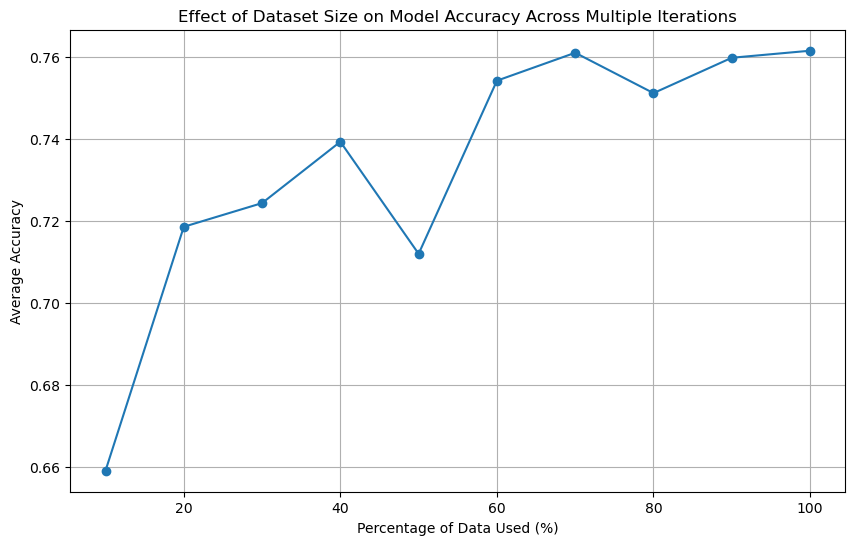

In [53]:
# Define the number of iterations for cross-validation
iterations = 10

# Sizes of the dataset to evaluate
steps = 10
step_size = 1 / steps
dataset_sizes = [step_size * i for i in range(1, steps + 1)]
mean_accuracies = []

for size in dataset_sizes:
    iteration_accuracies = []  # Store accuracies for each iteration

    for _ in range(iterations):        

        if size < 1.0:
            X_train, _, y_train, _ = train_test_split(X_sub, y, train_size=size, stratify=y, random_state=None)
        else:
            X_train, y_train = X_sub, y 

        clf = XGBClassifier(eval_metric='mlogloss', max_depth=7, n_estimators=101, learning_rate=0.05, subsample=0.7)
        skf = KFold(n_splits=10, shuffle=True, random_state=None)  # Random state None for different folds each iteration
        fold_accuracies = []

        for train_idx, test_idx in skf.split(X_train, y_train):
            X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
            y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

            clf.fit(X_fold_train, y_fold_train)
            preds = clf.predict(X_fold_test)
            fold_accuracies.append(accuracy_score(y_fold_test, preds))

        # Average accuracy for this fold
        iteration_accuracies.append(np.mean(fold_accuracies))

    # Average accuracy across all iterations for this dataset size
    mean_accuracies.append(np.mean(iteration_accuracies))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot([size * 100 for size in dataset_sizes], mean_accuracies, marker='o')
plt.title('Effect of Dataset Size on Model Accuracy Across Multiple Iterations')
plt.xlabel('Percentage of Data Used (%)')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.show()

PLOTTING ACCURACY VS NUMBER OF FEATURES USED

Validation Accuracy: 0.527 - Feature added: ip60_1 - Total features used: 1
Validation Accuracy: 0.537 - Feature added: ipmedian_1 - Total features used: 2
Validation Accuracy: 0.569 - Feature added: ip70_0 - Total features used: 3
Validation Accuracy: 0.655 - Feature added: ip90_1 - Total features used: 4
Validation Accuracy: 0.661 - Feature added: ip70_1 - Total features used: 5
Validation Accuracy: 0.652 - Feature added: ip80_1 - Total features used: 6
Validation Accuracy: 0.653 - Feature added: ip80_0 - Total features used: 7
Validation Accuracy: 0.665 - Feature added: 2binm2_1 - Total features used: 8
Validation Accuracy: 0.669 - Feature added: 2binx2_1 - Total features used: 9
Validation Accuracy: 0.669 - Feature added: 2binm2_0 - Total features used: 10
Validation Accuracy: 0.698 - Feature added: V_mean1 - Total features used: 11
Validation Accuracy: 0.710 - Feature added: istd_1 - Total features used: 12
Validation Accuracy: 0.727 - Feature added: 2binm2_2 - Total features used

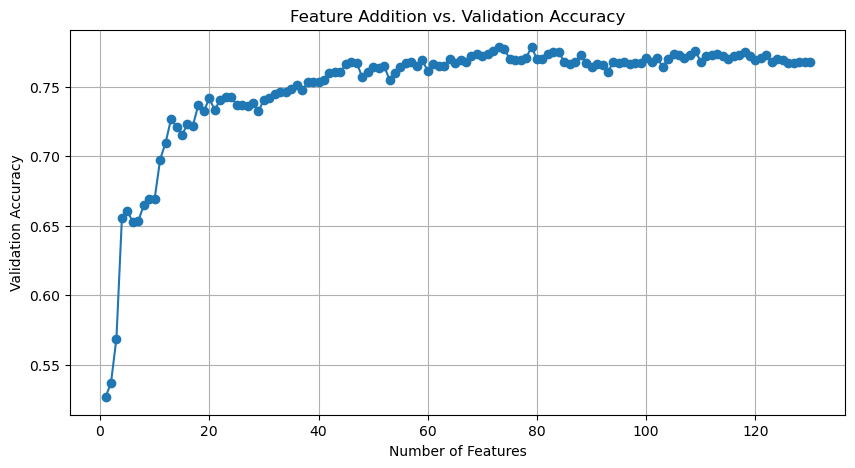

In [9]:

# Initialize variables
kf = KFold(n_splits=10, shuffle=True, random_state=42)
feature_importances = np.zeros(len(X_sub.columns))

# K-Fold Cross Validation to compute feature importances
for train_index, test_index in kf.split(X_sub, y):
    X_train_kf, X_test_kf = X_sub.iloc[train_index], X_sub.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    clf =  XGBClassifier(eval_metric='mlogloss', max_depth=7, n_estimators=101, learning_rate = 0.05, subsample=0.7)
    # clf = RandomForestClassifier(max_depth=14, n_estimators=101, class_weight='balanced')
    clf.fit(X_train_kf, y_train_kf)
    feature_importances += clf.feature_importances_
    
    preds_kf = clf.predict(X_test_kf)

# Average feature importances across all folds
feature_importances /= kf.get_n_splits()
feature_names = X_sub.columns

# Sort features by importance in descending order
sorted_features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)


# Iterative feature addition and re-evaluation
plot_data = []
selected_features = []
for feature_name, _ in sorted_features:
    selected_features.append(feature_name)
    
    # Recalculate K-Fold Cross Validation with the increasing feature set
    accuracies = []
    for train_index, test_index in kf.split(X[selected_features], y):
        X_train_kf, X_test_kf = X_sub[selected_features].iloc[train_index], X_sub[selected_features].iloc[test_index]
        y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

        clf.fit(X_train_kf, y_train_kf)
        preds_kf = clf.predict(X_test_kf)
        accuracies.append(accuracy_score(y_test_kf, preds_kf))
    
    avg_accuracy = np.mean(accuracies)
    plot_data.append((len(selected_features), avg_accuracy))
    print(f'Validation Accuracy: {avg_accuracy:.3f} - Feature added: {feature_name} - Total features used: {len(selected_features)}')

# Plotting
features, accs = zip(*plot_data)
plt.figure(figsize=(10, 5))
plt.plot(features, accs, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Validation Accuracy')
plt.title('Feature Addition vs. Validation Accuracy')
plt.grid(True)
plt.show()



FEATURE IMPORTANCES

In [48]:
# Initialize variables
kf = KFold(n_splits=10, shuffle=True, random_state=42)
feature_importances = np.zeros(len(X_sub.columns))

# K-Fold Cross Validation to compute feature importances
for train_index, test_index in kf.split(X_sub, y):
    X_train_kf, X_test_kf = X_sub.iloc[train_index], X_sub.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]
    
    clf =  XGBClassifier(eval_metric='mlogloss', max_depth=7, n_estimators=101, learning_rate = 0.05, subsample=0.7)
    # clf = RandomForestClassifier(max_depth=14, n_estimators=101, class_weight='balanced')
    clf.fit(X_train_kf, y_train_kf)
    feature_importances += clf.feature_importances_
    
    preds_kf = clf.predict(X_test_kf)

# Average feature importances across all folds
feature_importances /= kf.get_n_splits()
feature_names = X_sub.columns

# Sort features by importance in descending order
sorted_features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

In [49]:
sorted_features

[('V_mean1', 0.1801753059029579),
 ('V_median1', 0.14775127470493316),
 ('V_p901', 0.1305680625140667),
 ('V_sk1', 0.11597636416554451),
 ('V_std1', 0.11412629559636116),
 ('V_kut1', 0.10883810520172119),
 ('V_points', 0.10796737968921662),
 ('V_max1', 0.0945971816778183)]

KFOLD

In [73]:
# Setup the K-Fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)  # Adjust n_splits based on your preference

# Lists to store results of each fold
accuracies = []

feature_importances = np.zeros(len(X.columns))  # Array to sum up feature importances

# Loop over each fold
for train_index, test_index in kf.split(X, y):
    X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
    y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

    # Set up the classifier
    clf =  XGBClassifier(eval_metric='mlogloss', max_depth=7, n_estimators=101, learning_rate = 0.05, subsample=0.8)

    #clf =  RandomForestClassifier(max_depth=14, n_estimators=101, class_weight='balanced')

    # Train the classifier
    clf.fit(X_train_kf, y_train_kf)

    feature_importances += clf.feature_importances_

    # Predict on the test set
    preds_kf = clf.predict(X_test_kf)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_kf, preds_kf)
    accuracies.append(accuracy)

importances = feature_importances / kf.get_n_splits()

# Calculate average accuracy across all folds
average_accuracy = np.mean(accuracies)
print(f'Average K-Fold Accuracy: {average_accuracy:.3f}')

Average K-Fold Accuracy: 0.752


In [300]:
""" feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))

# Step 3: Sort the features based on importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True) """

# Print sorted features with their importances
for feature, importance in sorted_features:
    print(f'{feature}: {importance}')


ip60_1: 0.10698733478784561
ip70_0: 0.06282358653843403
ipmedian_1: 0.06174090690910816
ip90_1: 0.047126885131001474
ip70_1: 0.030410566180944443
ibinx3_1: 0.02706611044704914
V_mean: 0.024982125498354435
ip80_0: 0.023916908632963897
ip80_1: 0.021827164106070995
ibinm3_0: 0.021032267808914186
istd_1: 0.02084586163982749
ip60_0: 0.020401354320347308
ibinm3_2: 0.018762610759586094
ipmedian_0: 0.015090440027415752
ip20_1: 0.015052745398133994
ip10_1: 0.014461366087198257
ip40_0: 0.013687372393906116
ip90_0: 0.013346405234187841
ibinm2_0: 0.012635440751910209
ip30_0: 0.011766713298857211
imean_0: 0.011234879214316606
istd_0: 0.01122100567445159
ip40_1: 0.010888441186398267
irange_1: 0.01081046056933701
ipmedian_2: 0.01010953621007502
ip60_2: 0.010090349335223436
V_p90: 0.01002415493130684
V_std: 0.009872062969952822
isk_1: 0.009357515908777713
istd_2: 0.009302393347024918
ibinx3_0: 0.009264957066625357
imax_2: 0.009231626242399215
ibinx3_2: 0.008895742287859321
imax_1: 0.008703437773510814

In [301]:
# selected_features = [item[0] for item in sorted_features[:15]]

# selected_features = [feature_name for feature_name, importance in sorted_features if importance >= 0.008]
selected_features = [feature_name for feature_name, _ in sorted_features[:-15]]
# Subset your train and validation sets based on the selected features
X_sub = X_sub[selected_features]
print(len(selected_features))

62


K-FOLD WITH ITERATIONS

In [14]:
# Setup the number of K-Fold cross-validation iterations
num_iterations = 10  # You can adjust this number based on your needs

# Lists to store results of each iteration
iteration_accuracies = []

all_conf_matrices = []  # To store confusion matrices

# Perform multiple iterations of K-Fold cross-validation
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}/{num_iterations}")

    # Setup the K-Fold cross-validation
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42 + iteration)  # Adjust n_splits and random_state

    # Lists to store results of each fold
    accuracies = []
    fold_conf_matrices = []  # To store confusion matrices for each fold

    # Loop over each fold
    for train_index, test_index in kf.split(X_sub, y):
        X_train_kf, X_test_kf = X_sub.iloc[train_index], X_sub.iloc[test_index]
        y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

        # Set up the classifier
        clf = XGBClassifier(eval_metric='mlogloss', max_depth=7, n_estimators=101, learning_rate=0.05, subsample=0.8)

        # clf =  RandomForestClassifier(max_depth=14, n_estimators=101, class_weight='balanced')

        # Train the classifier
        clf.fit(X_train_kf, y_train_kf)

        # Predict on the test set
        preds_kf = clf.predict(X_test_kf)

        # Calculate accuracy
        accuracy = accuracy_score(y_test_kf, preds_kf)
        accuracies.append(accuracy)

        # Compute confusion matrix for the current fold
        conf_matrix = confusion_matrix(y_test_kf, preds_kf)
        fold_conf_matrices.append(conf_matrix)

    # Calculate average accuracy across all folds for this iteration
    average_accuracy = np.mean(accuracies)
    iteration_accuracies.append(average_accuracy)
    print(f'Average K-Fold Accuracy for Iteration {iteration + 1}: {average_accuracy:.3f}')

    # Sum confusion matrices across folds
    sum_conf_matrix = np.sum(fold_conf_matrices, axis=0)
    all_conf_matrices.append(sum_conf_matrix)

# Calculate overall average accuracy across all iterations
overall_average_accuracy = np.mean(iteration_accuracies)
print("")
print(f'Overall Average K-Fold Accuracy across {num_iterations} iterations: {overall_average_accuracy:.3f}')
print("")

# Average the confusion matrices across all iterations
avg_conf_matrix = np.mean(all_conf_matrices, axis=0)
row_sums = avg_conf_matrix.sum(axis=1)
percent_matrix = (avg_conf_matrix / row_sums[:, np.newaxis]) * 100
formatted_matrix = np.round(percent_matrix, 1)
print(formatted_matrix)


## RF:
# Depth: 14, n_estimators: 101, class_weight: balanced ---> 0.742

## XGBOOST:
# 0.757: subsample = 0.8


Iteration 1/10
Average K-Fold Accuracy for Iteration 1: 0.730
Iteration 2/10
Average K-Fold Accuracy for Iteration 2: 0.740
Iteration 3/10
Average K-Fold Accuracy for Iteration 3: 0.743
Iteration 4/10
Average K-Fold Accuracy for Iteration 4: 0.741
Iteration 5/10
Average K-Fold Accuracy for Iteration 5: 0.731
Iteration 6/10
Average K-Fold Accuracy for Iteration 6: 0.740
Iteration 7/10
Average K-Fold Accuracy for Iteration 7: 0.743
Iteration 8/10
Average K-Fold Accuracy for Iteration 8: 0.734
Iteration 9/10
Average K-Fold Accuracy for Iteration 9: 0.740
Iteration 10/10
Average K-Fold Accuracy for Iteration 10: 0.739

Overall Average K-Fold Accuracy across 10 iterations: 0.738

[[60.9  2.4 36.7]
 [11.  34.3 54.7]
 [ 8.5  1.8 89.7]]


RESULTS

In [ ]:
# GEO:
""" [[57.7  3.3 29.   3.5  3.8  1.6  0.3  0.9  0. ]
 [11.3 39.1 46.   0.7  2.5  0.1  0.1  0.2  0. ]
 [25.8  9.8 59.3  1.4  2.3  0.2  0.3  0.7  0. ]
 [25.6  1.5  5.3 56.5  2.2  6.8  0.3  1.8  0. ]
 [48.8  3.8 32.4  3.5  7.2  3.2  0.8  0.3  0. ]
 [26.5  3.   7.2 21.2  5.  30.2  0.   6.8  0. ]
 [39.   0.  20.5 19.   7.   2.5  5.5  6.5  0. ]
 [31.5  0.   3.5  6.2  0.5  4.   1.7 52.5  0. ]
 [42.7  5.3 32.7 13.3  0.   0.   6.   0.   0. ]] """

# RAD:
""" [[82.4  2.2 11.1  0.8  2.3  0.5  0.3  0.2  0. ]
 [ 9.3 68.  15.8  0.2  4.5  0.7  1.2  0.   0.3]
 [ 8.4  5.9 78.   0.7  4.9  0.1  0.6  1.3  0.1]
 [ 4.7  1.4  1.8 83.8  3.5  2.2  0.3  2.2  0.1]
 [ 7.7  9.2 17.8  1.9 56.9  2.   2.2  1.8  0.5]
 [ 9.   0.   6.5 19.   9.8 43.8  3.   9.   0. ]
 [14.   2.5  5.5  8.   8.5  9.5 37.5 14.   0.5]
 [12.5  1.5  6.7  5.  11.7  4.   4.  54.2  0.2]
 [ 0.  22.7 15.3  0.7 36.7  2.  13.3  7.3  2. ]] """

# RAD + GEO:
""" [[82.   2.6 10.9  0.8  2.7  0.6  0.3  0.   0. ]
 [ 9.7 67.8 17.1  0.1  3.9  0.   0.9  0.5  0. ]
 [ 8.4  5.1 79.6  0.7  5.2  0.2  0.3  0.5  0.1]
 [ 3.7  1.4  1.9 85.   2.9  5.1  0.   0.   0. ]
 [10.9  8.6 15.2  2.1 58.8  1.1  2.2  0.9  0.2]
 [ 9.2  0.   5.3 18.8  7.2 46.5  1.5 11.5  0. ]
 [ 8.   3.   5.  12.   7.  18.  37.5  9.5  0. ]
 [12.5  0.5  7.8  6.8  9.5  1.8  2.3 58.   1. ]
 [ 0.7 19.3  8.7  6.7 44.7  6.7  8.7  1.3  3.3]] """



# Voxel-size: 0.25
# V:
""" [[63.8  9.2 16.2  7.2  1.4  1.1  0.4  0.7  0. ]
 [27.7 24.7 38.7  2.5  3.4  0.9  1.   0.9  0.1]
 [10.8  7.9 71.1  1.8  5.7  1.1  0.6  0.8  0.2]
 [59.9  9.1  8.7 16.5  2.8  1.5  1.1  0.   0.4]
 [11.5 11.9 64.9  1.2  5.9  1.7  1.2  1.3  0.4]
 [37.2  4.2 40.8  7.8  9.5  0.5  0.   0.   0. ]
 [42.  14.  15.5  3.   6.   0.  15.5  4.   0. ]
 [23.  18.5 44.5  2.8  4.5  0.   3.2  2.   1.5]
 [22.7 14.7 52.7  1.3  4.   0.   4.7  0.   0. ]] """

# V + GEO:
""" [[71.9  3.9 13.4  5.8  2.8  1.6  0.2  0.6  0. ]
 [16.8 44.  33.9  1.3  3.7  0.2  0.1  0.   0.1]
 [11.4  7.1 73.3  0.7  5.5  0.7  0.3  0.8  0.2]
 [22.7  1.1  3.9 60.6  2.3  7.4  1.1  0.9  0. ]
 [17.4  4.2 54.6  2.5 18.1  2.2  0.2  0.8  0. ]
 [17.8  0.2 19.2 24.   4.5 25.5  0.   8.8  0. ]
 [42.   0.5 19.  15.   2.   1.  12.5  8.   0. ]
 [25.5  0.   9.   9.5  2.2  0.8  2.5 50.5  0. ]
 [20.   1.3 62.   6.7  4.7  0.   5.3  0.   0. ]] """

# V + RAD:
""" [[83.5  2.4 10.2  0.8  1.8  0.7  0.1  0.4  0. ]
 [ 8.6 68.  16.3  0.   4.5  0.5  2.   0.1  0.1]
 [ 7.6  6.  78.3  0.7  5.6  0.   0.4  1.4  0. ]
 [ 4.5  1.4  2.5 84.6  2.4  1.8  0.7  2.1  0. ]
 [ 8.8 10.  17.7  1.9 56.2  2.2  1.6  1.4  0.2]
 [ 6.8  0.   6.8 16.  11.8 46.8  2.  10.   0. ]
 [12.   3.5  5.   7.   8.5  4.5 45.5 14.   0. ]
 [13.   1.8  7.   5.   9.3  4.2  4.5 54.3  1. ]
 [ 0.7 20.  18.7  1.3 35.3  7.3  6.   5.3  5.3]] """

# V + GEO + RAD:
""" [[83.5  3.2  9.8  0.7  1.6  0.9  0.3  0.   0. ]
 [ 9.6 68.7 16.5  0.2  3.4  0.   1.2  0.4  0. ]
 [ 8.2  5.2 79.4  0.7  5.4  0.2  0.3  0.6  0.1]
 [ 4.4  1.   2.4 84.8  1.7  4.9  0.4  0.4  0. ]
 [ 9.4  9.9 15.3  2.  59.1  1.3  1.6  1.1  0.3]
 [ 7.2  0.   6.8 18.5  8.5 46.5  2.2 10.2  0. ]
 [11.   4.   5.  11.5  6.  13.5 36.  13.   0. ]
 [14.5  0.   7.5  7.2  7.8  1.7  1.2 58.   2. ]
 [ 6.  14.  13.3  5.3 44.   5.3  5.3  2.7  4. ]] """


# Voxel-size: 0.5
# V:
""" [[66.5  9.1 12.   7.6  2.1  0.8  1.   0.9  0. ]
 [20.5 20.8 45.3  1.8  8.8  0.9  0.5  1.5  0. ]
 [10.1 11.1 71.9  0.5  5.6  0.2  0.2  0.1  0.2]
 [68.2  7.6  6.6 14.1  1.8  0.4  0.8  0.2  0.3]
 [15.1 19.7 52.6  0.4  7.6  0.8  0.8  3.   0. ]
 [40.5 14.5 25.2  6.   4.8  6.5  0.   2.5  0. ]
 [41.5 15.5 16.   7.5  3.   0.  16.   0.5  0. ]
 [36.  21.7  9.5 11.2  3.5  4.5  1.2 12.3  0. ]
 [25.3  1.3 57.3  0.   8.   0.   0.   6.7  1.3]] """
# V + GEO:
""" [[73.5  2.7 13.   5.8  2.6  1.6  0.3  0.4  0. ]
 [14.8 44.4 34.3  1.8  4.2  0.3  0.1  0.1  0. ]
 [11.1  5.7 76.5  0.6  4.6  0.6  0.2  0.6  0. ]
 [29.6  1.   2.5 57.2  2.3  4.8  0.9  1.6  0.1]
 [16.2  4.1 50.4  1.5 24.9  2.5  0.   0.4  0. ]
 [17.8  0.2 18.  21.5  5.5 28.3  0.   8.8  0. ]
 [49.   3.  17.   7.5  1.5  1.  14.   7.   0. ]
 [27.   0.   9.5 10.   1.5  2.5  0.8 48.8  0. ]
 [14.7  2.7 57.3 12.   6.7  0.   6.7  0.   0. ]] """
# V + RAD:
""" [[85.   2.3  8.6  0.7  1.9  0.6  0.4  0.5  0. ]
 [ 7.5 69.1 16.1  0.   5.1  0.7  1.1  0.3  0.1]
 [ 7.3  5.4 80.3  0.7  4.4  0.2  0.6  1.1  0. ]
 [ 4.7  1.5  2.2 84.5  2.2  3.7  0.2  1.   0. ]
 [ 4.6 10.8 19.4  2.  56.3  2.1  2.7  1.5  0.6]
 [ 6.2  0.   8.5 15.5 11.5 49.5  0.2  8.5  0. ]
 [13.   1.   6.   8.5  9.5 10.  40.  12.   0. ]
 [12.5  1.2  7.5  5.3 11.   2.2  4.5 55.8  0. ]
 [ 0.7 14.7 13.3  6.7 42.7  5.3  8.7  2.   6. ]] """
# V + GEO + RAD:
""" [[84.6  2.9  8.9  0.8  1.5  0.8  0.3  0.1  0. ]
 [ 9.3 67.6 17.1  0.1  4.2  0.1  0.8  0.6  0.1]
 [ 6.8  5.2 80.7  0.7  5.2  0.2  0.4  0.7  0.1]
 [ 4.4  1.   2.6 85.   1.4  5.3  0.   0.3  0. ]
 [ 9.6  9.3 16.5  1.7 57.9  1.   2.4  1.1  0.5]
 [ 6.5  0.   6.5 19.   8.  48.3  1.5 10.2  0. ]
 [ 8.   1.   5.  11.5  9.5 16.5 40.5  8.   0. ]
 [14.3  0.   8.   7.   8.8  2.   2.5 56.2  1.2]
 [ 7.3  8.  15.3  5.3 45.3  4.7  7.3  1.3  5.3]] """


# Voxel-size: 1.0
# V:
""" [[68.7  4.5 13.   7.6  2.8  1.6  0.9  0.9  0. ]
 [22.8  9.9 56.3  1.3  7.9  0.1  0.5  1.1  0.1]
 [13.7  8.7 71.2  0.5  4.5  0.3  0.3  0.6  0.3]
 [60.9  3.2  3.5 21.7  2.2  3.4  0.3  4.8  0. ]
 [20.6 15.2 45.3  2.7 12.5  0.2  1.4  2.1  0. ]
 [45.5  3.8 20.2 16.   6.8  0.2  0.   7.5  0. ]
 [46.   9.  19.   2.5  1.5  0.  12.  10.   0. ]
 [50.5  2.5  1.2 15.8  0.8  5.   5.3 19.   0. ]
 [36.7 14.  36.7  2.   1.3  0.   2.   0.   7.3]] """

# V + GEO:
""" [[71.8  2.6 13.9  6.3  3.2  1.4  0.   0.8  0. ]
 [14.5 39.7 39.2  1.1  4.8  0.1  0.   0.5  0. ]
 [12.8  6.9 74.   1.1  3.9  0.6  0.1  0.5  0. ]
 [29.3  0.6  3.1 57.2  2.2  5.9  0.8  0.9  0. ]
 [26.8  3.3 39.4  1.9 25.4  2.2  0.5  0.5  0. ]
 [25.8  0.2 15.5 19.8  4.  26.2  0.   8.5  0. ]
 [49.   2.  20.5  6.   4.5  0.5 11.   6.5  0. ]
 [28.7  0.   4.  11.2  2.   1.7  0.5 51.7  0. ]
 [24.7  8.  40.  18.7  6.   0.   1.3  0.   1.3]] """

# V + RAD:
""" [[84.2  2.2 10.2  0.7  1.5  0.5  0.3  0.4  0. ]
 [ 9.3 68.9 14.8  0.   4.6  0.3  1.5  0.4  0.1]
 [ 8.1  5.7 79.2  0.7  4.3  0.3  0.7  1.   0. ]
 [ 4.1  1.5  2.1 85.1  2.4  3.9  0.   0.9  0. ]
 [ 7.  10.7 17.3  2.1 56.2  2.   2.9  1.7  0.1]
 [ 9.5  0.5  7.2 17.2  9.5 47.   0.   9.   0. ]
 [15.5  3.5  4.5  7.   6.5 10.  40.5 12.5  0. ]
 [14.   1.2  5.5  5.   8.   3.   4.  59.2  0. ]
 [ 0.  24.7 15.3  6.  32.7  5.3  6.7  2.   7.3]] """

# V + GEO + RAD:
""" [[83.5  2.5 10.3  0.8  1.7  0.7  0.4  0.1  0. ]
 [ 9.9 68.5 15.8  0.1  3.9  0.   1.3  0.5  0. ]
 [ 7.7  5.2 80.7  0.7  4.4  0.3  0.4  0.7  0. ]
 [ 4.1  1.   2.  84.8  2.1  5.6  0.   0.4  0. ]
 [ 9.8  9.6 16.   1.6 59.3  1.   1.9  0.8  0. ]
 [ 8.8  0.   5.3 18.5  8.  47.   1.  11.5  0. ]
 [ 8.5  1.5  5.  11.5  9.  17.  40.   7.5  0. ]
 [17.8  0.   5.5  6.2  7.8  1.5  2.2 57.8  1.2]
 [ 1.3 18.7 14.7  6.  39.3  6.7  6.7  1.3  5.3]] """


# Voxel-size: 2.0
# V:
""" [[56.9  4.2 24.3  9.6  1.8  1.3  0.8  1.1  0. ]
 [27.4  5.6 61.3  1.7  2.1  0.1  1.   0.9  0. ]
 [23.7 10.9 60.7  0.2  3.5  0.3  0.1  0.6  0. ]
 [57.7  1.2  7.8 24.4  0.6  3.6  0.6  4.1  0. ]
 [34.4  6.3 48.3  1.3  5.8  0.3  1.2  2.4  0. ]
 [49.3  3.  19.8 13.2  4.   5.8  0.   5.   0. ]
 [54.   5.  20.  10.   4.   0.   5.5  1.5  0. ]
 [54.2  0.2  4.5  5.5  1.2  7.5  2.5 24.2  0. ]
 [50.   6.7 37.3  0.7  2.   0.   3.3  0.   0. ]] """

# V + GEO:
""" [[66.7  3.  20.3  5.1  2.3  1.7  0.1  0.9  0. ]
 [15.1 38.3 42.8  0.2  3.7  0.   0.   0.   0. ]
 [20.8  7.6 66.1  1.   2.9  0.4  0.4  0.7  0. ]
 [27.8  0.5  5.2 58.5  0.9  5.4  0.3  1.4  0. ]
 [35.   3.7 39.5  1.6 16.7  2.6  0.2  0.7  0. ]
 [22.   1.7 10.5 24.   5.3 29.5  0.   7.   0. ]
 [54.5  2.  21.   3.   2.5  0.5 10.5  6.   0. ]
 [32.2  0.   2.2  9.   0.   6.2  1.5 48.8  0. ]
 [38.7  2.  40.7 12.7  0.   0.   6.   0.   0. ]] """

# V + RAD:
""" [[82.8  2.3 10.8  0.7  2.1  0.5  0.4  0.4  0. ]
 [ 8.8 68.9 15.9  0.   4.4  0.7  1.   0.3  0. ]
 [ 8.   4.9 79.9  0.7  4.9  0.2  0.6  0.8  0. ]
 [ 4.2  1.4  2.  84.3  2.2  3.6  0.   2.3  0. ]
 [ 8.  10.1 17.5  2.1 54.6  2.9  3.5  1.   0.3]
 [10.5  0.   6.8 18.2 10.8 46.5  0.2  7.   0. ]
 [ 9.   4.5  7.   8.   6.  10.  39.  13.   3.5]
 [12.3  1.5  2.5  5.3 11.   2.5  3.5 61.3  0.2]
 [ 0.  22.  15.3  6.7 38.7 10.   3.3  0.7  3.3]] """

# V + GEO + RAD:
""" [[81.9  2.6 11.1  0.7  2.4  0.8  0.2  0.1  0. ]
 [ 9.3 68.3 16.9  0.   4.1  0.1  0.7  0.7  0. ]
 [ 8.2  5.  80.5  0.7  4.5  0.2  0.2  0.6  0.2]
 [ 3.7  1.4  2.3 84.9  2.4  4.8  0.   0.5  0. ]
 [10.9 11.3 15.   2.  56.3  1.2  2.4  0.8  0.1]
 [ 9.8  0.   5.  19.   8.2 46.8  1.5  9.8  0. ]
 [ 8.   3.5  5.5 11.   6.5 18.5 39.   6.5  1.5]
 [13.8  0.5  4.5  6.8 10.5  2.   1.8 59.3  1. ]
 [ 0.  18.7 14.   5.3 40.   8.   8.7  1.3  4. ]] """


In [ ]:
# GEO:
""" [[58.7  3.3 28.7  5.5  3.8]
 [11.3 39.1 45.5  1.1  3.1]
 [25.2  9.1 59.6  2.7  3.3]
 [30.1  1.5  5.8 61.3  1.3]
 [50.3  4.5 32.4  4.3  8.5]] """

# RAD:
""" [[83.1  2.3 11.1  1.2  2.3]
 [10.7 67.7 15.6  0.2  5.8]
 [ 8.2  6.  78.4  0.9  6.5]
 [ 6.   1.   1.7 87.5  3.8]
 [10.3  9.2 17.7  3.7 59.1]] """

# RAD + GEO:
""" [[82.1  2.9 11.   1.3  2.7]
 [10.6 68.  16.5  0.5  4.4]
 [ 8.5  4.9 79.3  1.1  6.2]
 [ 5.7  1.3  1.4 88.8  2.8]
 [12.1  8.9 14.1  3.7 61.2]] """


# Voxel-size: 0.25
# V:
""" [[63.3 10.1 16.7  8.1  1.7]
 [28.  24.5 41.1  2.3  4.1]
 [11.7  8.1 71.9  2.   6.3]
 [60.2  9.6 10.2 16.9  3.1]
 [14.3 11.6 65.6  1.   7.5]] """

# V + GEO:
""" [[72.4  4.  14.1  7.1  2.4]
 [17.4 42.8 34.2  1.7  3.9]
 [12.   6.7 74.   1.   6.2]
 [24.7  1.   6.3 65.9  2.1]
 [18.2  4.4 57.6  2.9 16.9]] """

# V + RAD:
""" [[84.1  2.4 10.   1.4  2.1]
 [ 9.7 68.2 15.6  0.2  6.3]
 [ 7.6  5.5 78.9  1.   7. ]
 [ 4.9  1.   2.8 88.   3.3]
 [11.2 10.  16.8  3.7 58.3]] """

# V + GEO + RAD:
""" [[83.7  3.   9.8  1.3  2.1]
 [10.7 67.5 16.5  0.7  4.6]
 [ 7.6  5.6 80.1  1.   5.7]
 [ 4.7  1.5  2.8 88.9  2.1]
 [11.9  9.3 15.2  3.  60.6]] """



# Voxel-size: 0.5
# V:
""" [[67.6  9.1 12.4  8.2  2.7]
 [20.7 23.8 45.4  1.1  8.9]
 [10.8 10.9 71.9  0.4  6.1]
 [68.   8.2  7.5 14.3  2. ]
 [16.8 21.8 52.2  0.4  8.8]] """

# V + GEO:
""" [[74.7  2.8 12.   7.4  3. ]
 [15.6 44.3 33.9  2.4  3.9]
 [11.5  5.8 76.9  0.6  5.2]
 [32.   1.   2.9 62.   2.1]
 [17.9  4.6 51.4  2.3 23.8]] """

# V + RAD:
""" [[85.8  2.4  8.4  1.3  2.1]
 [ 9.1 68.1 15.8  0.3  6.6]
 [ 6.8  5.4 80.2  1.   6.6]
 [ 5.3  1.1  2.4 87.9  3.3]
 [ 8.  10.3 19.1  4.3 58.3]] """

# V + GEO + RAD:
""" [[85.3  2.5  8.8  1.2  2.2]
 [10.5 67.1 16.1  0.7  5.6]
 [ 7.1  5.3 80.6  1.1  5.9]
 [ 5.6  1.3  2.3 88.8  2. ]
 [11.4  8.8 16.6  3.4 59.8]] """


# Voxel-size: 1.0
# V:
""" [[70.8  4.3 13.4  8.8  2.8]
 [23.7 10.1 56.4  1.6  8.3]
 [14.   9.3 71.6  0.9  4.2]
 [64.4  2.9  3.5 25.7  3.5]
 [21.6 14.3 46.2  4.2 13.7]] """

# V + GEO:
""" [[73.6  2.8 12.9  7.3  3.3]
 [15.4 37.4 40.3  2.1  4.9]
 [13.5  6.6 74.9  1.1  3.9]
 [31.   0.5  3.6 62.6  2.3]
 [27.7  3.2 40.6  3.1 25.4]] """

# V + RAD:
""" [[84.9  2.1  9.9  1.3  1.8]
 [11.1 68.4 14.7  0.3  5.6]
 [ 8.   5.5 79.1  1.   6.4]
 [ 5.4  1.   1.9 88.   3.7]
 [ 9.7  9.7 15.8  3.8 61. ]] """

# V + GEO + RAD:
""" [[84.   2.6 10.   1.3  2.2]
 [12.9 67.2 15.4  0.5  4. ]
 [ 7.8  5.1 80.6  1.2  5.4]
 [ 5.5  1.4  2.  88.7  2.4]
 [11.   8.4 15.5  3.6 61.5]] """


# Voxel-size: 2.0
# V:
""" [[59.2  4.3 24.  10.1  2.4]
 [27.3  6.3 62.3  1.7  2.3]
 [23.5 10.5 61.5  0.6  3.9]
 [62.2  1.4  8.4 27.6  0.4]
 [38.1  6.1 48.2  1.8  5.8]] """

# V + GEO:
""" [[67.5  2.5 20.7  6.9  2.5]
 [15.  36.  45.   0.1  3.9]
 [21.2  7.8 66.4  1.2  3.4]
 [31.4  1.1  6.  61.1  0.4]
 [39.5  3.4 37.8  2.4 16.9]] """

# V + RAD:
""" [[82.9  2.1 11.3  1.4  2.3]
 [10.5 68.2 15.5  0.3  5.5]
 [ 8.1  5.4 78.9  1.   6.6]
 [ 6.   1.   2.  88.2  2.8]
 [ 9.1 10.  17.2  3.6 60.1]] """

# V + GEO + RAD:
""" [[82.3  2.5 11.4  1.3  2.5]
 [10.1 67.7 16.5  0.5  5.1]
 [ 8.7  4.6 79.3  1.2  6.2]
 [ 5.7  1.2  1.9 88.8  2.4]
 [12.5  9.  15.3  3.8 59.4]] """


In [ ]:
# GEO:
""" [[67.6  3.2 29.2]
 [12.5 38.5 49. ]
 [28.7  9.9 61.4]] """

# RAD:
""" [[84.4  2.9 12.7]
 [12.8 69.8 17.4]
 [11.1  7.  81.9]] """

# RAD + GEO:
""" [[85.3  2.9 11.7]
 [12.1 70.3 17.5]
 [11.2  5.7 83.1]] """


# Voxel-size: 0.25
# V:
""" [[71.7 10.5 17.7]
 [30.8 26.3 42.9]
 [14.   9.4 76.6]] """

# V + GEO:
""" [[79.9  3.9 16.2]
 [20.3 40.9 38.7]
 [14.1  7.1 78.9]] """

# V + RAD:
""" [[85.   2.7 12.3]
 [13.9 68.  18.1]
 [ 9.2  8.2 82.6]] """

# V + GEO + RAD:
""" [[86.4  2.9 10.7]
 [13.6 68.3 18.1]
 [ 9.9  6.7 83.4]] """


# Voxel-size: 0.5
# V:
""" [[76.  10.  14. ]
 [25.3 26.2 48.5]
 [11.8 13.  75.1]] """

# V + GEO:
""" [[81.8  3.7 14.5]
 [17.3 45.4 37.3]
 [13.1  5.8 81.1]] """

# V + RAD:
""" [[87.4  2.6  9.9]
 [12.6 68.9 18.5]
 [ 9.   7.1 84. ]] """

# V + GEO + RAD:
""" [[87.2  2.6 10.2]
 [12.7 69.7 17.7]
 [ 9.2  6.7 84.1]] """



# Voxel-size: 1.0
# V:
""" [[79.2  6.5 14.3]
 [26.  12.  62. ]
 [16.2 10.6 73.1]] """

# V + GEO:
""" [[82.1  3.1 14.8]
 [18.1 36.9 45. ]
 [15.3  6.7 78. ]] """

# V + RAD:
""" [[86.2  2.4 11.4]
 [13.  69.7 17.3]
 [ 9.8  7.3 82.9]] """

# V + GEO + RAD:
""" [[86.6  2.9 10.5]
 [13.7 68.9 17.4]
 [ 9.9  6.  84.1]] """



# Voxel-size: 2.0
# V:
""" [[68.8  5.2 26. ]
 [30.8  5.9 63.3]
 [25.7 10.8 63.5]] """

# V + GEO:
""" [[75.9  2.5 21.7]
 [16.6 35.5 47.9]
 [24.1  7.1 68.8]] """

# V + RAD:
""" [[84.8  2.5 12.7]
 [13.  70.3 16.7]
 [10.8  6.8 82.3]] """

# V + GEO + RAD:
""" [[85.4  2.9 11.7]
 [11.9 71.4 16.7]
 [11.5  5.9 82.6]] """

In [ ]:
# GEO:
""" [[28.6  2.1 69.3]
 [ 4.5 34.5 61. ]
 [11.7  4.6 83.6]] """

# RAD:
""" [[78.5  1.8 19.6]
 [ 8.1 62.3 29.6]
 [ 5.3  3.4 91.3]] """

# RAD + GEO:
""" [[76.8  2.1 21.1]
 [ 6.9 60.2 32.9]
 [ 5.1  2.  93. ]] """


# Voxel-size: 0.25
# V:
""" [[53.9  3.5 42.6]
 [13.6 10.4 76. ]
 [14.1  4.8 81.1]] """

# V + GEO:
""" [[58.8  2.9 38.3]
 [12.3 35.3 52.3]
 [ 9.1  2.7 88.2]] """

# V + RAD:
""" [[79.1  1.5 19.4]
 [ 7.1 60.7 32.2]
 [ 4.5  2.9 92.6]] """

# V + GEO + RAD:
""" [[79.3  1.9 18.8]
 [ 7.3 59.7 33.1]
 [ 4.2  2.2 93.6]] """


# Voxel-size: 0.5
# V:
""" [[55.   3.  42. ]
 [ 9.1  4.1 86.9]
 [15.3  4.3 80.4]] """

# V + GEO:
""" [[62.5  2.4 35.2]
 [ 8.6 38.3 53.1]
 [ 8.5  2.  89.5]] """

# V + RAD:
""" [[81.   1.5 17.5]
 [ 6.6 61.2 32.2]
 [ 4.3  2.6 93. ]] """

# V + GEO + RAD:
""" [[80.1  1.9 18. ]
 [ 6.9 60.1 33.1]
 [ 4.   2.  94. ]] """


# Voxel-size: 1.0
# V:
""" [[50.3  1.3 48.4]
 [11.2  3.1 85.7]
 [17.7  1.3 81. ]] """

# V + GEO:
""" [[58.4  2.2 39.5]
 [ 9.4 31.5 59.1]
 [10.2  2.7 87.1]] """

# V + RAD:
""" [[80.1  1.3 18.7]
 [ 7.1 61.4 31.5]
 [ 4.8  2.9 92.3]] """

# V + GEO + RAD:
""" [[79.6  1.8 18.6]
 [ 7.1 59.9 33.1]
 [ 4.7  2.3 93. ]] """


# Voxel-size: 2.0
# V:
""" [[29.3  1.6 69.1]
 [13.6  2.7 83.7]
 [18.3  2.7 78.9]] """

# V + GEO:
""" [[45.9  2.  52.1]
 [ 6.  31.4 62.6]
 [13.2  3.  83.8]] """

# V + RAD:
""" [[77.7  1.5 20.7]
 [ 7.3 62.9 29.8]
 [ 4.9  3.2 91.9]] """

# V + GEO + RAD:
""" [[77.2  1.8 21.1]
 [ 6.7 59.9 33.4]
 [ 5.1  2.  92.9]] """
